# KITE Tutorial: configuring a system and running a calculation



Import necessary packages

In [3]:
import pybinding as pb
import kite
import matplotlib.pyplot as plt
import numpy as np
import subprocess

from matplotlib import gridspec

Define plotting style and fonts

In [4]:
pb.pltutils.use_style()

<ipython-input-4-9b2b187421c3>:4: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  plt.rc('text.latex', unicode=True)


# Haldane model
We can define a Pybinding lattice object

In [5]:
from math import sqrt

a = 0.24595  # [nm] unit cell length
a_cc = 0.142 # [nm] carbon-carbon distance

def haldane(t, t_nn, phi, delta):
    """Return the lattice specification for Haldane model"""

    a = a_cc * sqrt(3)
    lat = pb.Lattice(a1=[a, 0], a2=[a / 2, a / 2 * sqrt(3)])

    # The next-nearest hoppings shift the Dirac point away from zero energy.
    # This will push it back to zero for consistency with the first-nearest model.

    lat.add_sublattices(
        ('A', [0, -a_cc / 2], delta),
        ('B', [0, a_cc / 2], -delta)
    )

    lat.add_hoppings(
        ([0, 0], 'A', 'B', t),
        ([1, -1], 'A', 'B', t),
        ([0, -1], 'A', 'B', t),
        ([0, 1], 'A', 'A', t_nn * np.exp(-1j * phi)),
        ([0, 1], 'B', 'B', t_nn * np.exp(1j * phi)),
        ([1, -1], 'A', 'A', t_nn * np.exp(-1j * phi)),
        ([1, -1], 'B', 'B', t_nn * np.exp(1j * phi)),
        ([1, 0], 'A', 'A', t_nn * np.exp(1j * phi)),
        ([1, 0], 'B', 'B', t_nn * np.exp(-1j * phi))
    )

    return lat

And plot the lattice

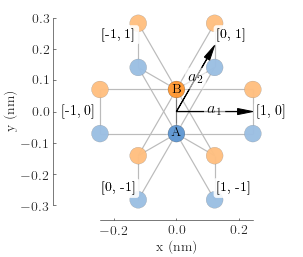

In [6]:
t = 1
t_nn = 1/3
from math import pi

lattice = haldane(t=t, t_nn=t_nn, phi=pi * 0.5, delta=2 * t_nn)
lattice.plot()

Disorder can be added using
``python
  kite.Disorder(lattice)
``
object via

In [7]:
# add Uniformly distributed disorder
disorder = kite.Disorder(lattice)
dis_std = 0.4
disorder.add_disorder('A', 'Uniform', +0.0, dis_std)
disorder.add_disorder('B', 'Uniform', +0.0, dis_std)

KITE accepts various configuration parameters, which define how a calculation will be executed.
For example
 * number of decomposition parts in each direction of matrix.
 * This divides the lattice into various sections, each of which is calculated in parallel

In [8]:
domain_decompose_1 = 2
domain_decompose_2 = 2
# number of unit cells in each direction.
lx = 128
ly = 128

num_moments = 512
configuration = kite.Configuration(divisions=[domain_decompose_1, domain_decompose_2],
                                   length=[lx, ly], boundaries=[True, True],
                                   is_complex=True, precision=0, spectrum_range=[-3.8, 3.8])
calculation = kite.Calculation(configuration)
# kite.config_system(lattice, configuration, calculation, filename='haldane_xx.h5',
#                    disorder=disorder)

# require the calculation of DOS and conductivity_dc
direction = 'xy'
num_random = 1
calculation.conductivity_dc(num_points=1000, num_moments=num_moments, num_random=num_random, num_disorder=1,
                            direction=direction, temperature=1)
# configure the *.h5 file
directory = ''
name = 'haldane_topol_{}_dis_std_{}_moments_{}_random_{}_lx_{}_ly_{}.h5'
full_name = directory + name.format(direction, dis_std, num_moments, num_random, lx, ly)
print(full_name)
kite.config_system(lattice, configuration, calculation, filename=full_name, disorder=disorder)

haldane_topol_xy_dis_std_0.4_moments_512_random_1_lx_128_ly_128.h5
##############################################################################
#                        KITE | Release  1.0                                 #
#                                                                            #
#                    Kite home: quantum-kite.com                             #
#                                                                            #
#                                                                            #
#                                                                            #
#  Developed by: Simao M. Joao, Joao V. Lopes, Tatiana G. Rappoport,         #
#                                                                            #
#  Misa Andelkovic, Lucian Covaci, Aires Ferreira, 2018-2020                 #
#                                                                            #
#                                                               

In [10]:
pb.utils.tic()  # measure the time
kite.KITEx(full_name)
pb.utils.toc('Time for moments calculation ')
kite.KITEtools(full_name + ' --CondDC -T 50 -F -3 3 10000 -E 4000 -K green 0.01 -N condDC_{}.dat'.format(direction))


Time for moments calculation  6.34s


0

In [ ]:
condDC = np.loadtxt('condDC_xy.dat')
cond_xy = pb.Series(condDC[:,0], condDC[:,1])
cond_xy.plot()

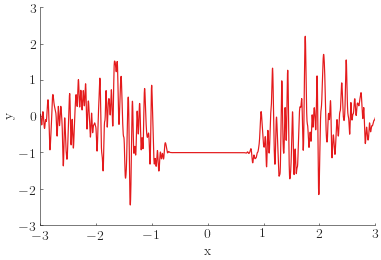